#Análisis del Problema

El conjunto de datos contiene información histórica de precios de acciones de empresas que forman parte del índice S&P 500 durante los últimos 5 años. Se pretende predecir el precio de Cierre de la acción.

## Descarga de los archivos de datos:
https://drive.google.com/file/d/12TRYx9djwlAvzhMpm5NpxYFRJbtQofTl/view?usp=sharing



### Autores
* Andrey Marín Chacón
* David González Agüero

#Entendimiento de los datos

El presente conjunto de datos contiene las siguientes características:

* **Date**: Fecha que indica el día al que corresponde la información.
* **Open**: El precio de apertura de la acción en el mercado al inicio del día, expresado en USD.
* **High**: El precio más alto alcanzado por la acción durante el día.
* **Low**: El precio más bajo alcanzado por la acción durante el día.
* **Close**: El precio de cierre de la acción al final del día.
* **Volume**: El número de acciones negociadas durante el día.
* **Name**: El nombre del ticker de la acción, que identifica a la empresa correspondiente.

#Exploración de los datos

## Imports

In [ ]:
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

##1. Lectura del conjunto de datos

In [ ]:
df = pd.read_csv("sample_data/all_stocks_5yr.csv")

##2. Visualización preliminar de la información

In [ ]:
df.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL


In [ ]:
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


Podemos observar con la descripción estadística que va a ser necesario aplicar escalado o normalización al conjunto de datos, esto debido a que las características tienen escalas muy diferentes. Por ejemplo, **close** tiene como valor mínimo 1.59 y valor máximo 2049.00, mientras que **low** tiene como valor mínimo 1.50 y máximo 2035.11.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


Ejecutando el siguiente comando para corroborar si existen o no valores nulos, nos muestra en el resultado que las características **open**, **high** y **low** tienen valores nulos.

In [ ]:
# Comprobación de si existen valores nulos
is_null = df.isna().any()
is_null[is_null]

open    True
high    True
low     True
dtype: bool

No existen valores infinitos porque nos retorna una lista vacía.

In [ ]:
# Comprobación de la existencia de valores infinitos
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

Series([], dtype: bool)

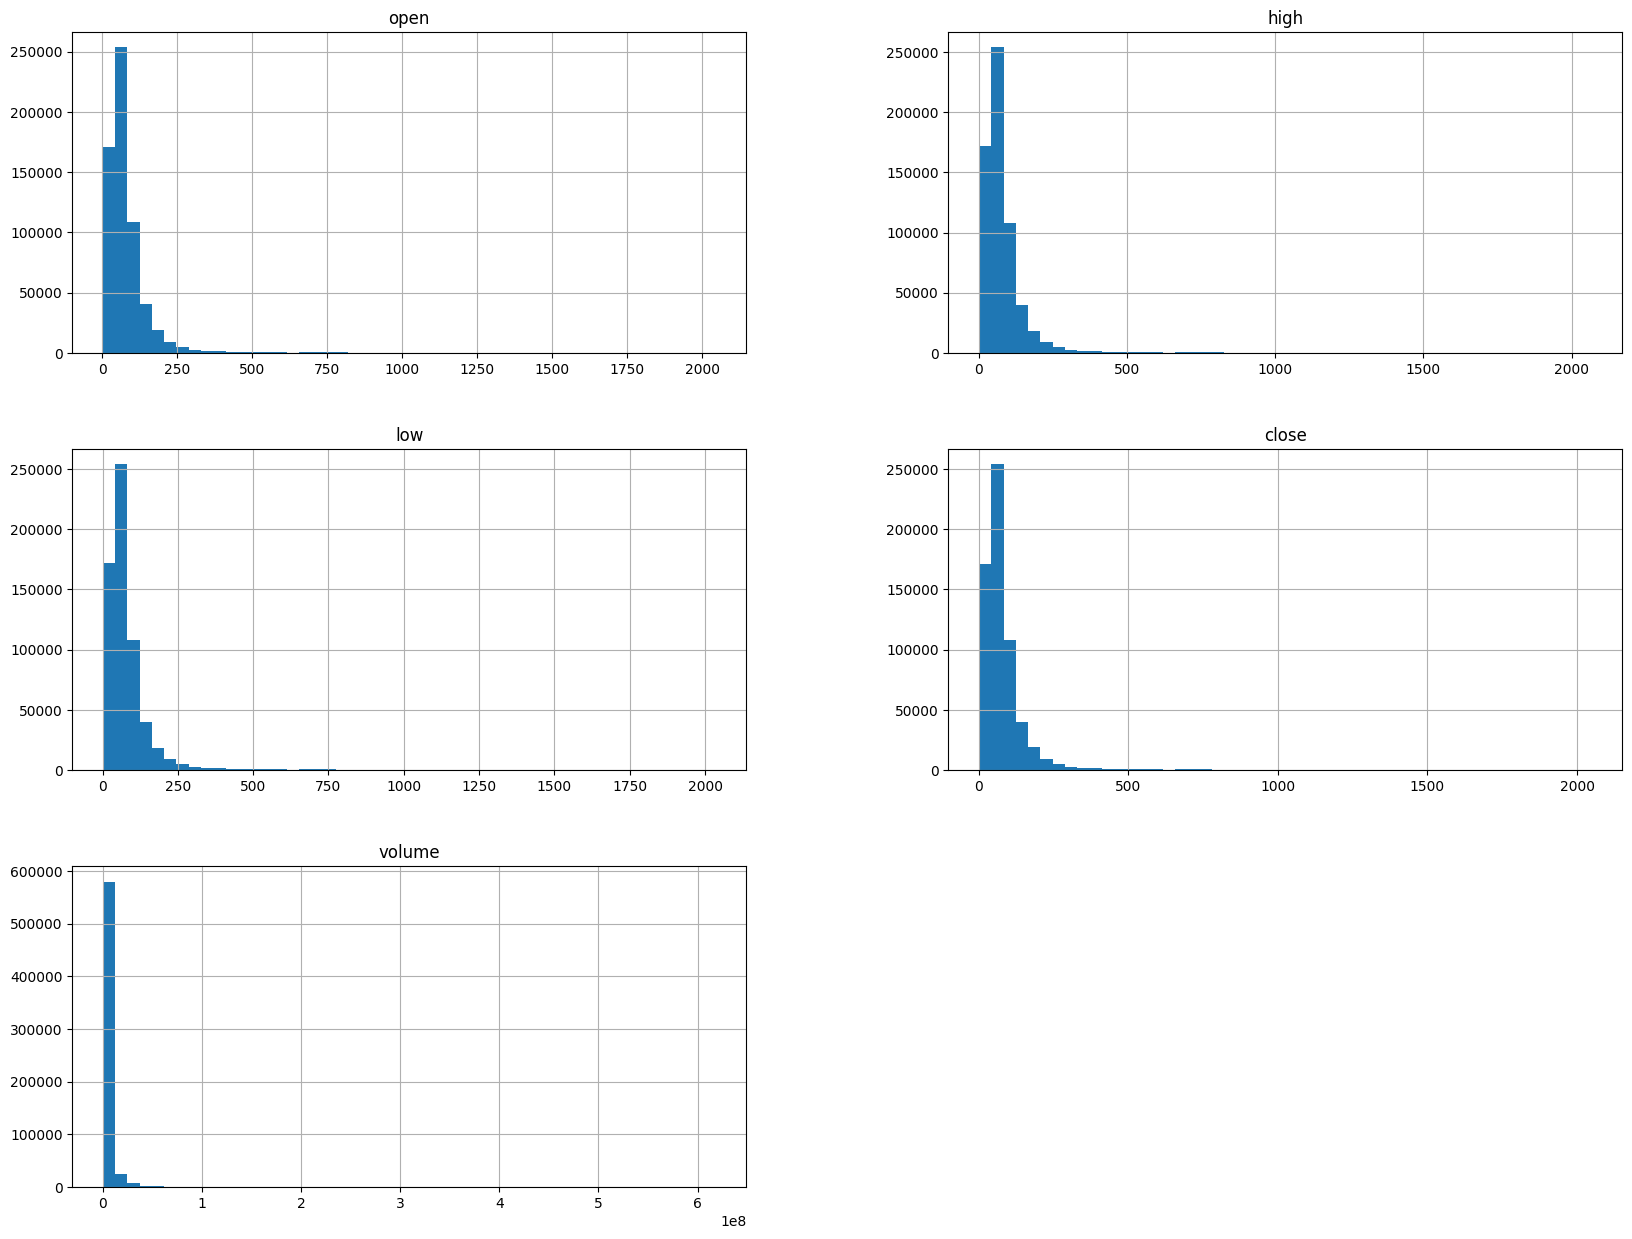

In [ ]:
# Representamos gráficamente la distribución de los atributos
df.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
# Transformamos los valores del atributo NAME de categoricos a numericos
labelencoder = LabelEncoder()
df["Name"] = labelencoder.fit_transform(df["Name"])
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,1
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,1
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,1
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,1
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,1
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,504
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,504
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,504
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,504


In [ ]:
#Mostramos correlación lineal entre todos los atributos del conjunto de datos
df.corr()

<ipython-input-16-5715cee15054>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,open,high,low,close,volume,Name
open,1.000000,0.999939,0.999928,0.999872,-0.142705,-0.032886
high,0.999939,1.000000,0.999903,0.999936,-0.142316,-0.032913
low,0.999928,0.999903,1.000000,0.999939,-0.143239,-0.032833
close,0.999872,0.999936,0.999939,1.000000,-0.142802,-0.032868
volume,-0.142705,-0.142316,-0.143239,-0.142802,1.000000,-0.060206
Name,-0.032886,-0.032913,-0.032833,-0.032868,-0.060206,1.000000


En la siguiente instrucción podemos ver que hay una fuerte correlación entre **close** que es la variable de salida con **low**, **high** y **open**:

In [ ]:
# Mostrar la correlación entre los atributos del conjunto de datos
corr_matrix = df.corr()
corr_matrix["close"].sort_values(ascending=False)

<ipython-input-18-7d82797c6f59>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


close     1.000000
low       0.999939
high      0.999936
open      0.999872
Name     -0.032868
volume   -0.142802
Name: close, dtype: float64

<ipython-input-19-ff788cbb99c3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


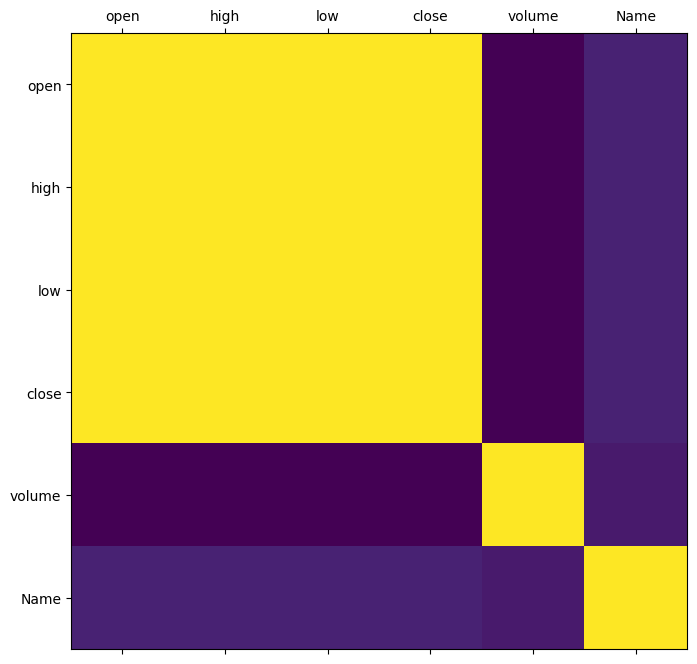

In [ ]:
# Representar gráficamente la matriz de correlación
corr = df.corr()
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

Como se observa en la matriz de correlación, también las características **high**, **low** y **open** se correlacionan bastante entre ellas mismas, por lo que al final basta solamente con elegir una característica para predecir la variable y = **close**

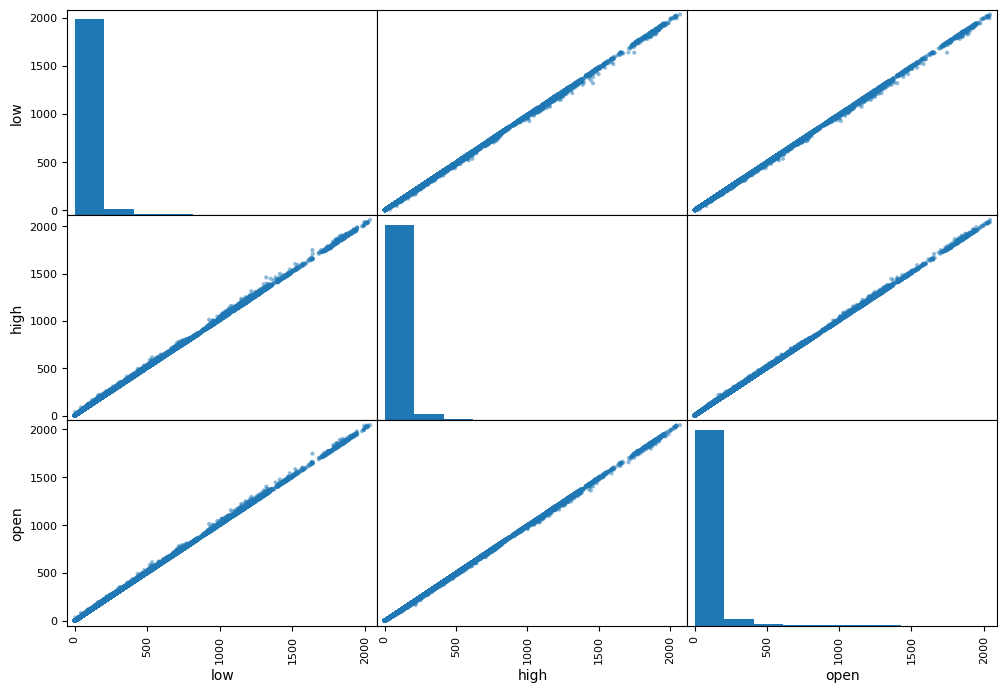

In [ ]:
# Correlaciones representadas gráficamente
atributos = ["low", "high", "open"]

scatter_matrix(df[atributos], figsize=(12, 8))
plt.show()

##3. Division del conjunto de datos

In [ ]:
# División del conjunto de datos 70/30 ya que son poquitos datos
train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433328 entries, 475906 to 121958
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    433328 non-null  object 
 1   open    433322 non-null  float64
 2   high    433324 non-null  float64
 3   low     433324 non-null  float64
 4   close   433328 non-null  float64
 5   volume  433328 non-null  int64  
 6   Name    433328 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 26.4+ MB


In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185712 entries, 252249 to 383479
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    185712 non-null  object 
 1   open    185707 non-null  float64
 2   high    185708 non-null  float64
 3   low     185708 non-null  float64
 4   close   185712 non-null  float64
 5   volume  185712 non-null  int64  
 6   Name    185712 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 11.3+ MB


In [ ]:
# Separamos las características de entrada de la característica de salida, también eliminamos date ya que no nos aporta gran cosa.
X_train = train_set.drop(["close", "date"], axis=1)
y_train = train_set["close"].copy()

X_test = test_set.drop(["close", "date"], axis=1)
y_test = test_set["close"].copy()

##4. Preparación del conjunto de datos

In [ ]:
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train['open'].values.reshape(-1,1))

X_train_scaled = pd.DataFrame(X_train_scaled, columns=['open'])
X_train['open'] = X_train_scaled

In [ ]:
robust_scaler = RobustScaler()
X_test_scaled = robust_scaler.fit_transform(X_test['open'].values.reshape(-1,1))

X_test_scaled = pd.DataFrame(X_test_scaled, columns=['open'])
X_test['open'] = X_test_scaled

In [ ]:
X_train

,open,high,low,volume,Name
475906,NaN,65.79,64.21,26515424,388
377112,0.849678,92.49,91.34,840607,310
159601,1.207176,82.23,80.00,4992803,131
507496,NaN,83.18,81.54,14383826,414
532,0.622907,55.93,54.37,19042013,1
...,...,...,...,...,...
110268,-0.264949,69.60,68.87,2882888,91
259178,8.748666,27.24,26.83,2603039,213
365838,0.112236,130.54,129.16,4287051,301
131932,1.988960,20.57,20.32,6050495,109


In [ ]:
X_test

,open,high,low,volume,Name
252249,NaN,778.1800,767.23,1488059,206
154331,0.775872,101.8400,100.66,8345174,127
507080,NaN,83.2800,82.02,5832542,414
215553,NaN,88.5300,87.52,3652475,177
301370,NaN,141.7000,140.94,953284,248
...,...,...,...,...,...
546026,NaN,94.0597,93.16,1167948,446
319875,NaN,65.7600,64.60,13193497,263
478651,NaN,543.1199,530.16,507771,393
82773,-0.661197,50.4200,49.06,2490963,66


Al aplicar escalado en la columna open nos ha generado algunos valores nulos:

In [ ]:
# Comprobación de si existen valores nulos
is_null = X_train.isna().any()
is_null[is_null]

open    True
high    True
low     True
dtype: bool

In [ ]:
# Comprobación de si existen valores nulos
is_null = X_test.isna().any()
is_null[is_null]

open    True
high    True
low     True
dtype: bool

In [ ]:
#Rellenamos los valores nulos con la mediana
imputer = SimpleImputer(strategy="median")

X_train_prep = imputer.fit_transform(X_train)

In [ ]:
#Rellenamos los valores nulos con la mediana
imputer = SimpleImputer(strategy="median")

X_test_prep = imputer.fit_transform(X_test)

In [ ]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns = X_train.columns, index=y_train.index)

In [ ]:
# Transformamos el resultado a un DataFrame de Pandas
X_test_prep = pd.DataFrame(X_test_prep, columns = X_test.columns, index=y_test.index)

In [ ]:
X_train_prep.head(10)

,open,high,low,volume,Name
475906,-0.000368,65.79,64.2100,26515424.0,388.0
377112,0.849678,92.49,91.3400,840607.0,310.0
159601,1.207176,82.23,80.0000,4992803.0,131.0
507496,-0.000368,83.18,81.5400,14383826.0,414.0
532,0.622907,55.93,54.3700,19042013.0,1.0
598194,-0.000368,85.87,84.9900,2861522.0,485.0
221306,0.314627,131.99,130.0683,2299379.0,183.0
66098,-0.259430,70.74,69.6600,4154402.0,54.0
444711,-0.000368,108.38,107.1700,3446464.0,363.0
499321,-0.000368,54.47,53.3600,11944370.0,407.0


In [ ]:
X_test_prep.head(10)

,open,high,low,volume,Name
252249,-0.001492,778.1800,767.2300,1488059.0,206.0
154331,0.775872,101.8400,100.6600,8345174.0,127.0
507080,-0.001492,83.2800,82.0200,5832542.0,414.0
215553,-0.001492,88.5300,87.5200,3652475.0,177.0
301370,-0.001492,141.7000,140.9400,953284.0,248.0
3357,0.494499,157.4600,153.8900,2680412.0,2.0
137587,-0.145441,178.4900,175.9700,258352.0,113.0
348770,-0.001492,26.6400,26.2686,1229536.0,288.0
338229,-0.001492,72.6600,72.0600,984779.0,279.0
382195,-0.001492,42.7533,41.1933,9762693.0,314.0


In [ ]:
# Comprobación de si existen valores nulos
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

In [ ]:
# Comprobación de si existen valores nulos
is_null = X_test_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

#Modelo Regresión Lineal Simple

In [ ]:
# COnstrucción del modelo y ajuste de la función hipótesis
lin_reg = LinearRegression()
lin_reg.fit(X_train_prep['high'].values.reshape(-1, 1), y_train)

LinearRegression()

In [ ]:
#Hacemos las predicciones
y_pred = lin_reg.predict(X_test_prep['high'].values.reshape(-1, 1))
y_pred

array([771.64172881, 100.95415147,  82.54926423, ..., 538.5461127 ,
        49.96388736, 110.64249998])

In [ ]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 2.48


In [ ]:
# El mejor puntaje es el que esta cercano a 1
print('Variance Score: %.2f' % r2_score(y_test, y_pred))

Variance Score: 1.00


In [ ]:
lin_reg.score(X_test_prep['high'].values.reshape(-1, 1), y_test)

0.9997474676095891

#Evaluación

In [ ]:
# Parámetro theta 0
lin_reg.intercept_

-0.0347341141017381

In [ ]:
# Parámetro theta 1
lin_reg.coef_

array([0.99164263])

In [ ]:
# Predicción para el valor mínimo y máximo del conjunto de datos de entrenamiento
X_min_max = np.array([[X_train_prep["high"].min()], [X_train_prep["high"].max()]])
y_train_pred = lin_reg.predict(X_min_max)

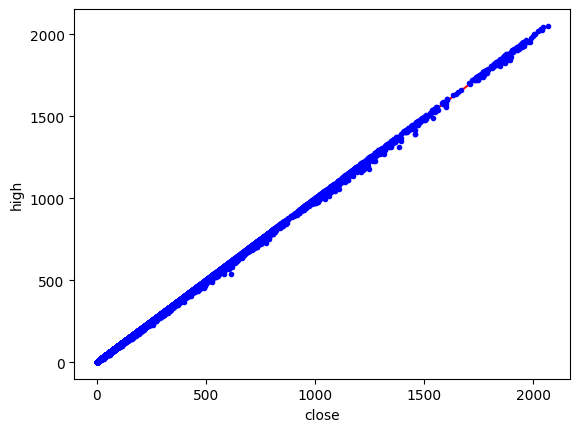

In [ ]:
# Representación gráfica de la función hipótesis generada
plt.plot(X_min_max, y_train_pred, "r-")
plt.plot(X_train_prep['high'], y_train, "b.")
plt.xlabel("close")
plt.ylabel("high")
plt.show()

In [ ]:
# Salvar el modelo en archivo .pkl
joblib.dump(lin_reg, "02PrecioAcciones.pkl")

['02PrecioAcciones.pkl']

In [ ]:
# Cargar modelo
#regLinealCargado = joblib.load("02PrecioAcciones.pkl")

#Conclusión
Como podemos observar en la gráfica el modelo de regresión lineal simple se adapta bastante bien al conjunto de datos de entrenamiento. El modelo predice un 99% de la variabilidad de los datos. Por lo que se recomienda en su uso en este escenario.